# Модуль В. Тестирование разработанной модели

В этом модуле мы сегодня протестируем наши модели yolov5 + easyocr по детекции и распознаванию автомобильных номеров на тестовых данных, предоставленных организаторами.

## Тест кейсы

Для начала загрузим папку с тест кейсами в директорию нашего модуля(./test_cases). В этой папке находятся директории test case 1 - test case 7 в каждой из которых есть по три изображения

Создадим код в котором мы загрузим наши модели и прогоним каждую фотографию из кейсов. 

In [1]:
import os
from glob import glob
import torch
import easyocr
# Модернизированная функция получения результата, оптимизированная для тест кейсов
def predicts(img, detect_model, reader_model):
    # Кропп изображения
    model = detect_model
    reader = reader_model
    results = model(img) # Детекция номеров на изображении
    output = []
    if not results.xyxy[0].nelement() == 0:
        for i, res in enumerate(results.xyxy):
            print(f'Машина {i+1}:')
            crop_xy = list(map(int,(res.detach().flatten()[0],res.detach().flatten()[1],res.detach().flatten()[2],res.detach().flatten()[3]))) # преобразование результатов детекции в формат xyxy
            img = img[crop_xy[1]:crop_xy[3],crop_xy[0]:crop_xy[2]] # Кропп изображения слайсингом
            # Чтение надписей на изображении
            result = reader.readtext(img) # работа модели по прочтению текста
            # Преобразование результата в понятную форму и вывод результата
            result = [result[i][1] for i in range(len(result))]
            for re in result:
                print(re)
            output.append(result)
        return output
    else:
        print('Номер не распознан')
        return [[False]]
# Функция получения изображения
def take_picture(path):
    import cv2
    img = cv2.imread(path)
    return img
# Обозначим модели до функции чтобы несколько раз не загружать в пустую и тратить время
model = torch.hub.load('./yolov5', 'custom', path='./yolov5/runs/train/exp6/weights/last.pt' ,source='local')# Обозначение модели детекции изображений
reader = easyocr.Reader(['en','ru'],gpu = False) # обозначение модели читающей текст с картинки
# Далее получим данные о директориях и их изображениях в тест кейсах
path = './test_cases' # Путь к директории с тест кейсами
results = [] # Список записи результатов
for test_case in os.listdir('./test_cases'): # в test_case записываем по очереди название каждой директории с тест кейсами
    print('Это тест кейс из папки: ', test_case)
    img_res = []
    for i, img_path in enumerate(glob(os.path.join(path, test_case,'*'))): # И находим относительный путь к картинкам
        img = take_picture(img_path)
        print(f'Фотография номер {i+1}')
        img_res.append(predicts(img,model,reader)) # Берём результаты работы моделей
    results.append(img_res)

YOLOv5  2024-3-12 Python-3.11.8 torch-2.2.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 
Using CPU. Note: This module is much faster with a GPU.


Это тест кейс из папки:  test case 1
Фотография номер 1
Машина 1:
[5:
[241ут]
Фотография номер 2
Машина 1:
IP
Я00АР 35
Фотография номер 3
Номер не распознан
Это тест кейс из папки:  test case 2
Фотография номер 1
Машина 1:
[35"
В
Б92ук:
Фотография номер 2
Машина 1:
Фотография номер 3
Машина 1:
47200 35
Это тест кейс из папки:  test case 3
Фотография номер 1
Машина 1:
4707уг
Фотография номер 2
Машина 1:
SSUxAus
Фотография номер 3
Номер не распознан
Это тест кейс из папки:  test case 4
Фотография номер 1
Машина 1:
ЧZUОH 5
Фотография номер 2
Машина 1:
tE397AA 35;
Фотография номер 3
Машина 1:
[в053РА
Это тест кейс из папки:  test case 5
Фотография номер 1
Машина 1:
8518TT 35
Фотография номер 2
Машина 1:
P5eits
Фотография номер 3
Машина 1:
[о04BсА
Это тест кейс из папки:  test case 6
Фотография номер 1
Машина 1:
с48Зху 197
RUS
Фотография номер 2
Машина 1:
м63 Mxi7
Фотография номер 3
Машина 1:
508А775
Это тест кейс из папки:  test case 7
Фотография номер 1
Машина 1:
Фотография номер 2
Машина

Кстати если использовать модель yolov5 через torch как я её использую, все библиотеки вывода изображений переходят в режим, в который не отрисовывают графики в коде, поэтому отобразить фото рядом с текстом может быть сложно

Я перезагрузил ядро кнопочка кстати наверху под вкладками с ноутбуками:

![](./static/1.png)

Короче сохраним результаты модели в pickle файл, потому что ядро я перезагружаю а результаты из-за этого не оставляются

In [2]:
import pickle
with open('./static/results.pickle','wb') as f:
    pickle.dump(results,f)

Ну и перезагрузив ядро загружаем наши данные:

In [1]:
import pickle
with open('./static/results.pickle','rb') as f:
    results = pickle.load(f)
print(results)

[[[['[5:', '[241ут]']], [['IP', 'Я00АР 35']], [[False]]], [[['[35"', 'В', 'Б92ук:']], [[]], [['47200 35']]], [[['4707уг']], [['SSUxAus']], [[False]]], [[['ЧZUОH 5']], [['tE397AA 35;']], [['[в053РА']]], [[['8518TT 35']], [['P5eits']], [['[о04BсА']]], [[['с48Зху 197', 'RUS']], [['м63 Mxi7']], [['508А775']]], [[[]], [['133', "'YCUS]"]], [['[ВА31PA 35']]]]


Надеюсь ниче не поломается

И теперь заново составив тот же код нахождения путя к изображениям отобразим на каких данных мы тестировали наши модели

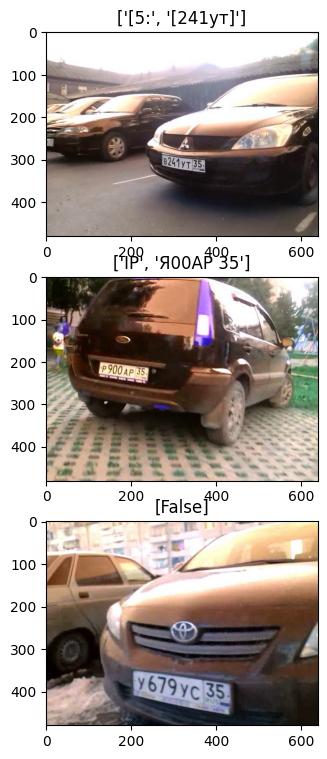

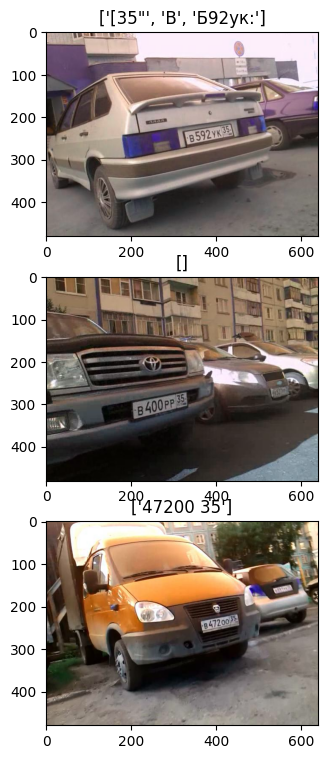

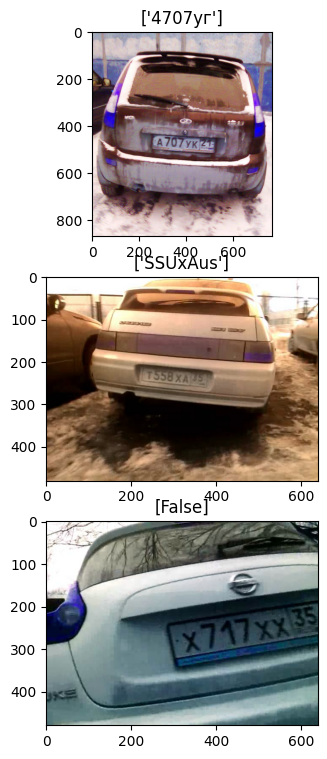

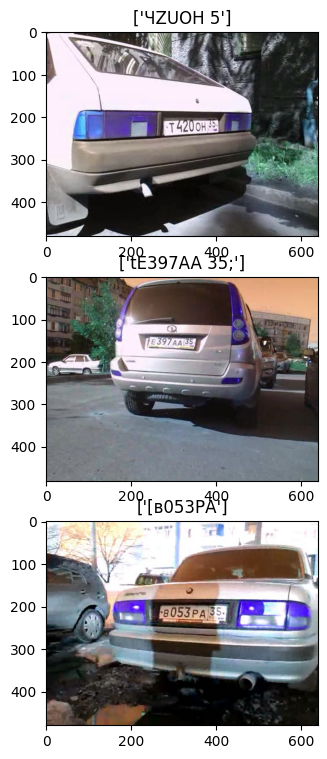

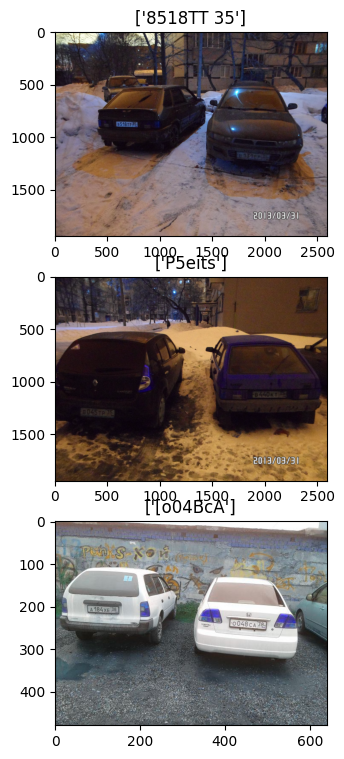

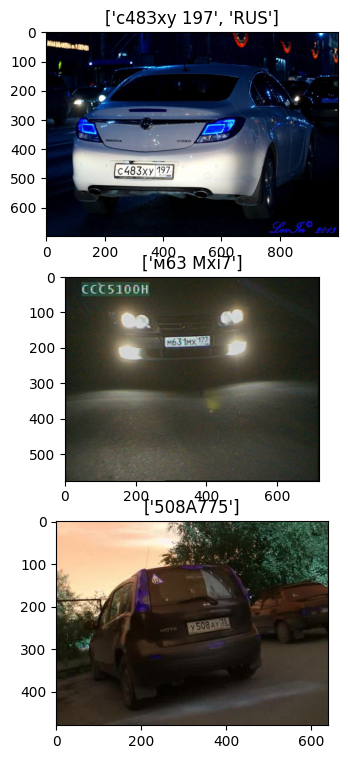

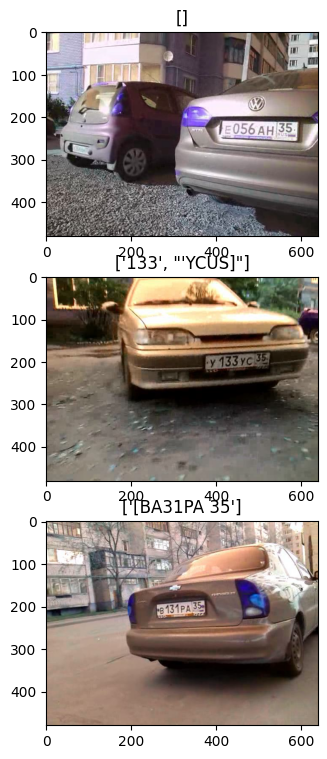

In [7]:
import matplotlib.pyplot as plt
import os
from glob import glob
def take_picture(path):
    import cv2
    img = cv2.imread(path)
    return img
path = './test_cases' # Путь к директории с тест кейсами
for test_case in os.listdir('./test_cases'): # в test_case записываем по очереди название каждой директории с тест кейсами
    j = int(test_case[-1])-1
    fig,axes = plt.subplots(3,1,figsize=(12,9))
    for i, img_path in enumerate(glob(os.path.join(path, test_case,'*'))): # И находим относительный путь к картинкам
        img = take_picture(img_path)
        axes[i].imshow(img)
        axes[i].set_title(results[j][i][0])

Урра работает

Да, в скобочках но а че модель так выводит

Так вот, в ходе тестирования наших моделей оказалось что в них есть недостатки, например если наш номер слишком близко модель yolo может не справится с детекцией т.к. либо мало было данных о изображениях где номера близко, либо модель не обучилась хорошо за определённое количество эпох. Есть к чему стремиться, дополнять данные, размечать их лучше и обучать на лучших параметрах.

# Тест API

### Тест работы API

### Тест загрузки изображений

### Тест получения результата

Для этого я создам видео-отчёт/инструкцию в папке ./videos

И назвал я его Тест API и его функций.mkv

Вот уже и папку создал кстати

In [8]:
import os
os.mkdir('./videos')

В видео вы можете увидеть как я загружаю своё api с нуля, копируя его из предыдущего модуля. Как я проверяю работу своего решения и делаю выводы на основе полученных результатов. Проверяю работу ввода изображения в котором выяснил некоторые недостатки кода которые должны быть учтены и исправлены. 

Также я сделал некоторую обновку в своём апи, показываю на видео ./videos/Нововведение.mkv